# Self-supervised and multi-modal representation Learning: Notebook 2

Here we will build a simple encoder for light curves, and try to train it to learn useful representation via masked autoencoding (i.e., predicting a missing part of the light curve).

## Light curve encoding via masked self-supervised learning

In [1]:
import sys, os

sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import torch
from torch.utils.data import DataLoader
import math

import torch
import torch.nn as nn
import pytorch_lightning as pl

from src.transformer_utils import TransformerWithTimeEmbeddings

from src.dataloader import SimulationLightcurveDataset, SimulationDataset

from src.models_pretraining import *

from src.utils import assert_sorted_lc

%load_ext autoreload
%autoreload 2

### Data loading and pre-processing

Let's start by loading the BTS data. The data contain variable number of light curves. For those with >100 observations pick 100 at random. Pad the shorter ones with zeros up to a length of 100. We'll also create a padding mask to be used in the encoder.

In [14]:
bands = ["r", "g"]
dataset = SimulationDataset(
    hdf5_path="sim_data/ZTF_Pretrain_5Class_ZFLAT_PERFECT.hdf5",
    bands=bands,
    n_max_obs=100,
    combinations=["lightcurve"],
    dataset_length=10000,
    noise=False,
)

In [15]:
loader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=4)
assert_sorted_lc(loader, bands)

### Light curve encoder

We'll start with a simple transformer-based light curve encoder. Since transformers are inherenently permutation-equivariant (i.e., insensitive to ordering -- a permutation of the inputs leads to a corresponding permutation of the outputs), we'll need to add time encodings to "tell" the transformer the time corresponding to each observation. 

This is a simple way to be able to deal with variable-length, heterogeneously sampled light curves. There are many extensions to this basic idea, see e.g.
- https://arxiv.org/abs/2309.16316
- https://arxiv.org/abs/2308.06404
- https://www.aanda.org/articles/aa/full_html/2023/02/aa43928-22/aa43928-22.html

and feel free to implement ideas from these or others, e.g. learnable time encoding bases.

PyTorch has a boilerplate Transformer implementation (`nn.TransformerEncoder`), but we'll use a lower-level implementation in `models/transformer_utils.py` for a bit more flexibility if we need it. Feel free to play around with either in the block below, inspecting the outputs and their shape, effect of masking, effect of changing hyperparameters.

Now let's implement the light curve encoder. For more details on the time-encoding via fourier features, please see e.g., [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#Positional-encoding), from where it was adapted. We'll include the time encoding dependence simply by adding the embeddings to the linear embeddings of individual light curve data points.

### Dataset prep and masking

Write a convenience function to get masks for the encoder.

In [16]:
mlce = MaskedLightCurveEncoder(
    f_mask=0.15,
    lr=6e-4,
    nband=2,
    transformer_kwargs={
        "n_out": 32,
        "emb": 32,
        "heads": 2,
        "depth": 9,
        "dropout": 0.0001988,
    },
)
# Load pretrained
pretrain_lc_path = "analysis/./4x2kdxcj/soft-sweep-2/epoch=14-step=870.ckpt"
mlce.load_state_dict(torch.load(pretrain_lc_path)["state_dict"])

<All keys matched successfully>

In [77]:
mask_in, mask_pred = get_continous_random_mask(padding_mask, len(bands), f_mask=0.15)

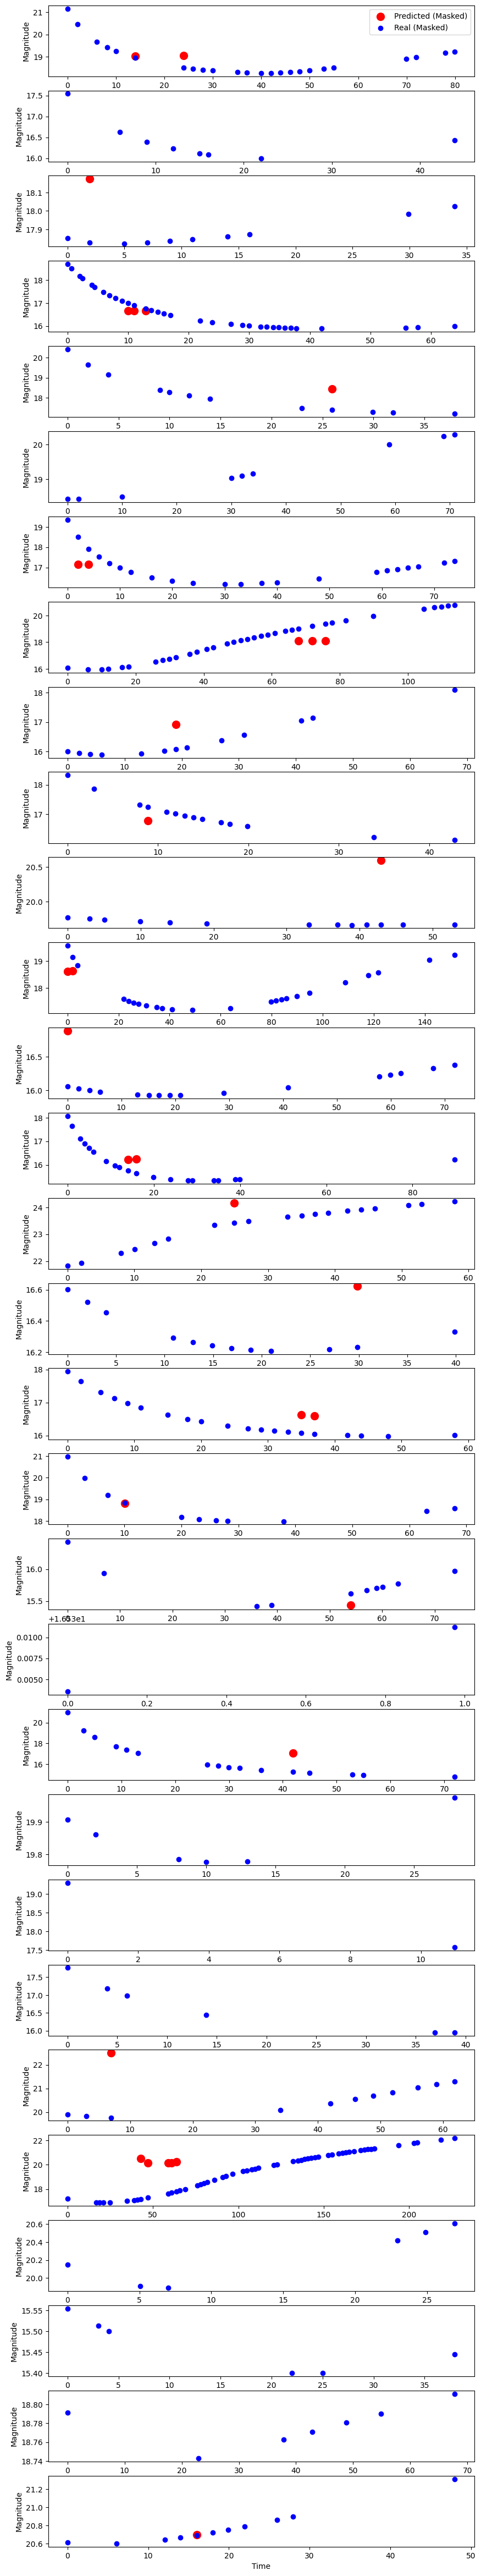

In [85]:
batch = next(iter(loader))
_, mag_test, time_test, padding_mask, spec, freq, maskspec, redshift, _ = batch

nbands = len(bands)
mask_in, mask_pred = get_continous_random_mask(padding_mask, nbands, f_mask=0.10)
x_masked = mag_test.clone()
x_masked[~mask_in] = 0  # Mask out the selected parts of the input
x_pred = mlce(x_masked, time_test, mask=padding_mask)

number_of_plots = 30
fig, axs = plt.subplots(number_of_plots, 1, figsize=(10, 60))

N = time_test.shape[1]
for i in range(number_of_plots):
    # sorted_indices = torch.argsort(time_test[i])
    t = time_test[i][: N // nbands]
    mask = mask_pred[i][: N // nbands]
    general_mask = padding_mask[i][: N // nbands]
    x_pred_sorted = x_pred[i][: N // nbands]
    mag_test_sorted = mag_test[i][: N // nbands]

    # Predicted data (masked)
    x_tmp = x_pred_sorted[mask]
    t_tmp = t[mask]

    axs[i].scatter(
        t_tmp.detach().numpy(),
        x_tmp.detach().numpy(),
        color="red",
        s=100,
        label="Predicted (Masked)",
    )
    # Real data (masked)
    x_real = mag_test_sorted[general_mask]
    t_real = t[general_mask]
    axs[i].scatter(
        t_real.detach().numpy(),
        x_real.detach().numpy(),
        color="blue",
        label="Real (Masked)",
    )

    # Setting labels and legends
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Magnitude")
    axs[0].legend()
#   axs[i].set_ylim([14,22])
plt.show()

In [90]:
from src.models_multimodal import (
    ConvMixer,
    TransformerWithTimeEmbeddings,
    LightCurveImageCLIP,
)

model = LightCurveImageCLIP(
    logit_scale=1000,
    lr=1,
    nband=2,
    loss="softmax",
    transformer_kwargs={
        "n_out": 80,
        "emb": 256,
        "heads": 4,
        "depth": 12,
        "dropout": 0.002,
    },
    # transformer_spectral_kwargs=transformer_spectral_kwargs,
    # conv_kwargs=conv_kwargs,
    # optimizer_kwargs={},
    combinations=["host_galaxy", "lightcurve"],
)

In [91]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.05
batch_size = 512
n_samples_val = int(val_fraction * len(dataset))

# dataset = TensorDataset(mag, time, mask)
# dataset = PaddedSinusoidDataset(n_max_obs=80, amp_range=(0.20, 0.50), num_samples=1000,freq_range = (0.05,0.05))
dataset_train, dataset_val = random_split(
    dataset, [len(dataset) - n_samples_val, n_samples_val]
)
train_loader = DataLoader(
    dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False
)

In [92]:
trainer = pl.Trainer(max_epochs=5, accelerator="gpu")
trainer.fit(model=mlce, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TypeError: __init__() missing 1 required positional argument: 'step_size'